# Goal

* Map incorporators on the phylogeny

# Setting variables

In [49]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [50]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data'
figDir = '/home/chantal/Chazy/Bulk/515_806/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core'
#physeqBulk = 'bulk-core' 

l2fcResFile_till = file.path(workDir, 'l2fc_Till.txt')
l2fcResFile_OM = file.path(workDir, 'l2fc_sparse-maxRejH_bulk_OM.txt')

## NOTEBOOK RUN WITH 0.25 SPARSITY FILTERED DATASET...

nprocs = 20

# Init

In [51]:
%%R
library(phyloseq)
library(dplyr)
library(tidyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(foreach)
library(doParallel)

# Loading files

In [52]:
%%R 

F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk= rarefy_even_depth(physeq.Bulk, sample.size = 9500, rngseed = 23435, replace = TRUE,
                          trimOTUs = TRUE, verbose = TRUE)

physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 18140 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 18140 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 18140 tips and 18139 internal nodes ]


In [53]:
%%R 

#F = file.path(physeqDir, physeqBulk)
#physeq.bulk = readRDS(F)
#physeq.bulk.m = physeq.bulk %>% sample_data
#physeq.bulk

NULL


In [54]:
%%R 
# log2 fold change analysis results file
df.l2fc.Till = read.delim(l2fcResFile_till, sep='\t')
df.l2fc.Till$p_till = df.l2fc.Till$padj2 
df.l2fc.Till$LFC_Till = df.l2fc.Till$log2FoldChange
df.l2fc.Till$padj2 = NULL
df.l2fc.Till$log2FoldChange = NULL
df.l2fc.Till = select(df.l2fc.Till, -lfcSE, -sparsity_threshold, -padj)
df.l2fc.Till %>% head(n=3)


       OTU    Rank1            Rank2          Rank3                  Rank4
1 OTU.1739 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium
2 OTU.1813 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium
3  OTU.778 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium
  Rank5 Rank6 Rank7 Rank8 Till       p_till   LFC_Till
1  <NA>  <NA>  <NA>  <NA>    T 0.6010558483  0.4012126
2  <NA>  <NA>  <NA>  <NA>    N 0.0056520888 -1.4802581
3  <NA>  <NA>  <NA>  <NA>    N 0.0009556926 -0.5498601


In [55]:
%%R 
# log2 fold change analysis results file
df.l2fc.OM = read.delim(l2fcResFile_OM, sep='\t')
df.l2fc.OM$p_OM = df.l2fc.OM$padj2 
df.l2fc.OM$LFC_OM = df.l2fc.OM$log2FoldChange
df.l2fc.OM$padj2 = NULL
df.l2fc.OM$log2FoldChange = NULL
df.l2fc.OM$OM2[df.l2fc.OM$p_OM <= 0.10 & df.l2fc.OM$LFC_OM <0] = 'Harvested'
df.l2fc.OM$OM2[df.l2fc.OM$p_OM <= 0.10 & df.l2fc.OM$LFC_OM >0] = 'Returned'
df.l2fc.OM$OM2[df.l2fc.OM$p_OM > 0.10] = 'Unenriched'



df.l2fc.OM = select(df.l2fc.OM, -lfcSE, -sparsity_threshold, -padj, -OM)
df.l2fc.OM %>% head(n=3)

       OTU    Rank1            Rank2          Rank3                  Rank4
1 OTU.1739 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium
2 OTU.1813 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium
3  OTU.778 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium
  Rank5 Rank6 Rank7 Rank8      p_OM      LFC_OM        OM2
1  <NA>  <NA>  <NA>  <NA> 0.2826947 -0.99492092 Unenriched
2  <NA>  <NA>  <NA>  <NA> 0.9999966 -0.34779469 Unenriched
3  <NA>  <NA>  <NA>  <NA> 0.9999966  0.08123953 Unenriched


In [56]:
%%R
df.l2fc = full_join(df.l2fc.Till, df.l2fc.OM)
df.l2fc$OM2[is.na(df.l2fc$OM2)] = 'Not Present'
head(df.l2fc)


        OTU    Rank1            Rank2          Rank3                  Rank4
1  OTU.1739 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium
2  OTU.1813 Bacteria __Planctomycetes        __OM190 __uncultured_bacterium
3   OTU.778 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium
4  OTU.2180 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium
5 OTU.12365 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium
6  OTU.2343 Bacteria __Planctomycetes __Pla4_lineage __uncultured_bacterium
  Rank5 Rank6 Rank7 Rank8 Till       p_till   LFC_Till      p_OM      LFC_OM
1  <NA>  <NA>  <NA>  <NA>    T 0.6010558483  0.4012126 0.2826947 -0.99492092
2  <NA>  <NA>  <NA>  <NA>    N 0.0056520888 -1.4802581 0.9999966 -0.34779469
3  <NA>  <NA>  <NA>  <NA>    N 0.0009556926 -0.5498601 0.9999966  0.08123953
4  <NA>  <NA>  <NA>  <NA>    N 0.5116160300 -0.3066501 0.9999966  0.01465938
5  <NA>  <NA>  <NA>  <NA>    N 0.7656246065 -0.1443963 0.6026827 -0.52013058
6  <NA

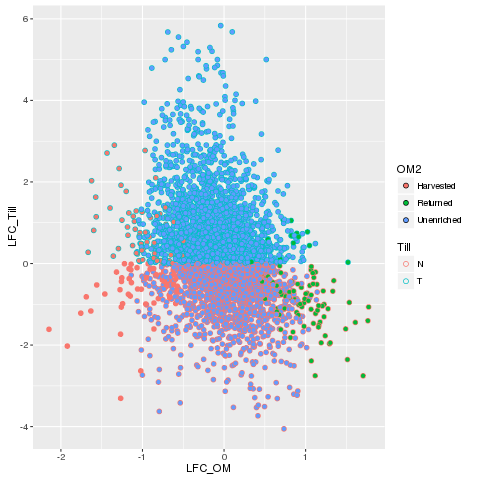

In [57]:
%%R
ggplot(data = df.l2fc, aes(LFC_OM, LFC_Till)) +
geom_point(aes(color = Till, fill = OM2), size = 2, shape = 21) 

## Making tree plot & metadata plots separately, then combining with grid.arrange

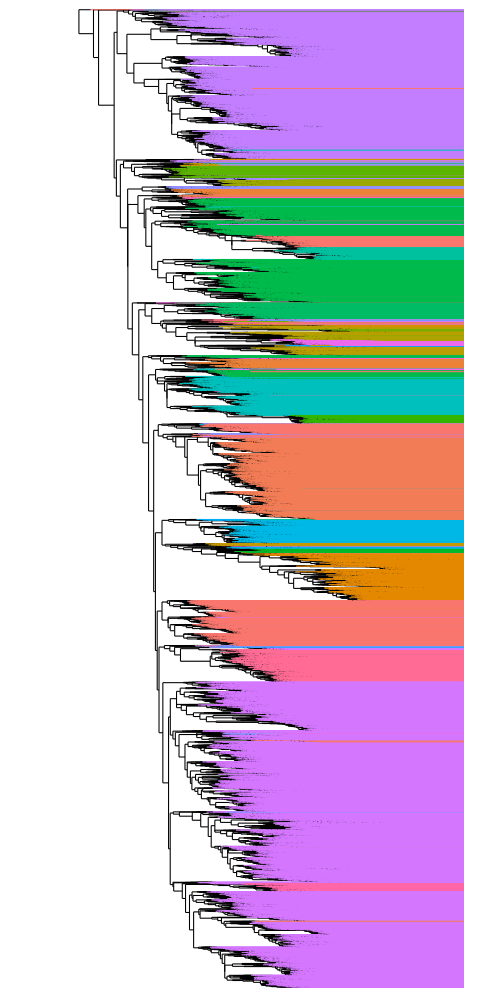

In [58]:
%%R -h 1000

plot_tree = function(physeq, color.rank="Rank2", legend.title='Phylum', 
                     plot.margin=NULL, y.expand=c(0.01,0.01),
                     legend.position='none', legend.size=4){
    # general tree plotting with ggplot
    as.Num = function(x){ x %>% as.character %>% as.numeric }
    
    # plot margin
    if(is.null(plot.margin)){
        plot.margin = unit(c(0,0,0,0), "cm")  # top, right, bottom, left        
    }

    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_inner = treeSegs$edgeDT[is.na(treeSegs$edgeDT$OTU)]
    edge_otu = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)]

    # adding taxonomy to left edges
    physeq.tax = physeq %>% tax_table %>% as.matrix %>% as.data.frame %>%
        mutate(OTU = rownames(.))
    edge_otu.df = edge_otu %>% as.matrix %>% as.data.frame %>%
        mutate(xleft = xleft %>% as.Num,
               xright = xright %>% as.Num,
               y = y %>% as.Num)
    edge_otu.df = inner_join(edge_otu.df, physeq.tax, c('OTU' = 'OTU')) %>%
        mutate(Rank2 = gsub('^__', '', Rank2),
               Rank3 = gsub('^__', '', Rank3),
               Rank4 = gsub('^__', '', Rank4),
               Rank5 = gsub('^__', '', Rank5),
               Rank6 = gsub('^__', '', Rank6),
               Rank7 = gsub('^__', '', Rank7),
               Rank8 = gsub('^__', '', Rank8)) 
    
    # adding node-metadata connector lines
    edge_otu.con = edge_otu.df %>%
                     mutate(max.xright = max(xright, na.rm=T),
                            xleft = xright,
                            xright = max.xright)
    
    # dummy facet
    edge_inner$FACET = 1
    
    # making tree plot
    p.tree = ggplot(data=edge_inner) + 
        geom_segment(aes(x=xleft, xend=xright, y=y, yend=y)) + 
        geom_segment(data=edge_otu.df, 
                     aes(x=xleft, xend=xright, y=y, yend=y)) +
        geom_segment(data=edge_otu.con,
                     aes_string(x="xleft", xend="xright", y="y", 
                                yend="y", color=color.rank)) + 
        geom_segment(data=treeSegs$vertDT, 
                     aes(x=x, xend=x, y=vmin, yend=vmax)) +
        scale_y_continuous(expand=y.expand) +
        scale_color_discrete(legend.title) +
        facet_grid(. ~ FACET) +
        theme_bw() +
        guides(colour = guide_legend(override.aes = list(size=legend.size))) +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            legend.position = legend.position,
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank(),
            plot.margin = plot.margin
            )
    return(p.tree)
    }

#-- test --#
p.tree = plot_tree(physeq.Bulk, 
          legend.title='Phylum', 
          legend.position='none', 
          plot.margin=unit(c(0,-0.1,0,2),'cm'))
p.tree

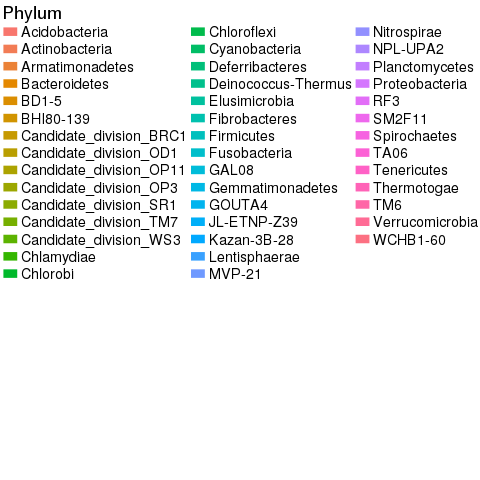

In [59]:
%%R

g_legend = function(a.gplot, text.size = 18, legend.position=c(0.5, 0.7)){ 
    # function for plotting just legend
    a.gplot = a.gplot + theme(legend.position=legend.position, 
                              text = element_text(size=text.size))
    tmp = ggplot_gtable(ggplot_build(a.gplot)) 
    leg = which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
    legend = tmp$grobs[[leg]] 
    return(legend)
    } 
                        
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [60]:
%%R 

as.Num = function(x){ x %>% as.character %>% as.numeric }

order_metadata_to_tree = function(physeq, metadata){
    # function for parsing & giving y (y.tree) value to metadata
        
    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_otu.df = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)] %>%
                as.matrix %>% 
                as.data.frame %>%
                mutate(y.tree = y %>% as.Num) %>%
                select(OTU, y.tree)
    
    # joining leaf edge and metadata
    inner_join(edge_otu.df, metadata, c('OTU' = 'OTU'))     
    }

#-- test --#
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)

df.l2fc.ord = order_metadata_to_tree(physeq.Bulk, df.l2fc.s) 
df.l2fc.ord %>% head(n=4)

       OTU y.tree Till       p_till   LFC_Till      p_OM      LFC_OM        OM2
1 OTU.1739  18135    T 0.6010558483  0.4012126 0.2826947 -0.99492092 Unenriched
2 OTU.1813  18136    N 0.0056520888 -1.4802581 0.9999966 -0.34779469 Unenriched
3  OTU.778  18132    N 0.0009556926 -0.5498601 0.9999966  0.08123953 Unenriched
4 OTU.2180  18124    N 0.5116160300 -0.3066501 0.9999966  0.01465938 Unenriched


In [61]:
%%R 

# calc wUnifrac distance
calc.wunif.dist = function(physeq, cores=8){
    registerDoParallel(cores=cores)
    wunif.dist = distance(physeq.Bulk,
                          method = "unifrac", 
                          weighted = TRUE,
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(wunif.dist)
    }


# ordering substrates by w-unifrac distances between incorporators
order_substrates_by_incorps = function(metadata, physeq, padj.cutoff=0.10, ...){
   
    # filtering physeq to just incorporators
    incorps = metadata %>%
        filter(p_till <= padj.cutoff | p_OM <= padj.cutoff)
    taxa.names = taxa_names(physeq)
    taxa.to.rm = taxa.names[taxa.names %in% incorps$OTU]
    physeq.cut = prune_taxa(taxa.to.rm, physeq)
    # merging samples by substrate
    physeq.cut.merge = merge_samples(physeq.cut, "Till")
    
    # removing 12C-con
    #physeq.md = physeq.cut.merge %>% sample_data
    #physeq.md$Treatment = rownames(physeq.md)
    #sample_data(physeq.cut.merge) = physeq.md
    #physeq.cut.merge = prune_samples(physeq.md$Treatment != '12C', physeq.cut.merge)
        
    # w-unifrac
    wunif.dist = calc.wunif.dist(physeq.cut.merge, ...)
        
    # hclust of w-unifrac values
    wunif.clust = hclust(wunif.dist, method='average')
    
    # ordering metadata by hclust ordering
    Till = metadata$Till %>% as.vector %>% unique
    Till = Till[wunif.clust$order]
    metadata$Till = factor(metadata$Till, levels=Till)
    
    return(metadata)
}

#-- test --#
#calc.wunif.dist(physeq.thresh, cores=20)
df.l2fc.ord2 = order_substrates_by_incorps(df.l2fc.ord, physeq.Bulk, cores=nprocs)
df.l2fc.ord2 %>% head(n=4)

       OTU y.tree Till       p_till   LFC_Till      p_OM      LFC_OM        OM2
1 OTU.1739  18135    T 0.6010558483  0.4012126 0.2826947 -0.99492092 Unenriched
2 OTU.1813  18136    N 0.0056520888 -1.4802581 0.9999966 -0.34779469 Unenriched
3  OTU.778  18132    N 0.0009556926 -0.5498601 0.9999966  0.08123953 Unenriched
4 OTU.2180  18124    N 0.5116160300 -0.3066501 0.9999966  0.01465938 Unenriched


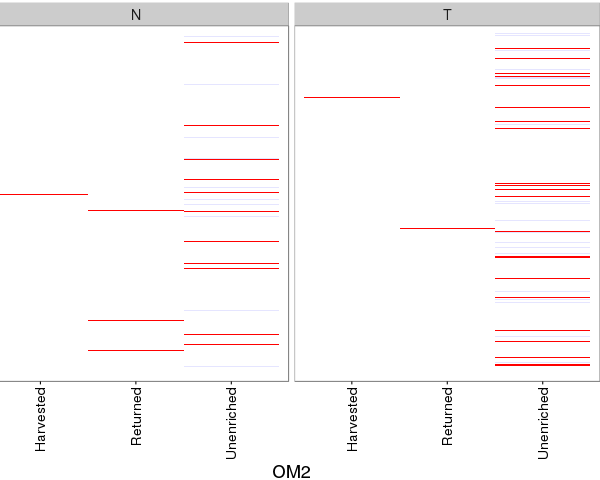

In [62]:
%%R -w 600

# function for making incorporator plot
incorp_plot = function(metadata, plot.margin=NULL){
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,0,-0.7), "cm")  # top, right, bottom, left        
    }
    
    metadata.ord = metadata %>%
        mutate(incorporator = p_till <= 0.10 | p_OM <= 0.10,
               incorporator.num = incorporator %>% as.numeric)#,
               #Month = Month %>% as.character)
    
  #  metadata.ord$Month = factor(metadata.ord$Month, levels = c("April", "June", "July", "August", "September", "October", "November"))

    min.y = metadata.ord$y.tree %>% min(na.rm=T)
    max.y = metadata.ord$y.tree %>% max(na.rm=T)    
    
    p.incorp = ggplot(metadata.ord, aes(OM2, y.tree, fill=incorporator, alpha=incorporator.num)) +
        geom_tile() +
        scale_fill_manual(values=c('blue', 'red')) +
        scale_y_continuous(expand=c(0,0)) +
        facet_grid(~ Till, scales='free_x') +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(angle=90, vjust=0.5, hjust=1, size = 14),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin, text =element_text(size =18)    
            )   
    return(p.incorp)
    }

#-- test --#
p.incorp = incorp_plot(df.l2fc.ord2)
p.incorp

In [63]:
%%R -w 800 -h 500
    
resize_ggplots = function(ggplot.list,
                          resize.index = length(ggplot.list),
                          widths=rep(1, length(ggplot.list))){
    # other.plots = list of plots
    stopifnot(class(ggplot.list)[1] == 'list')
    
    ## making gtables
    make_gt = function(x) ggplot_gtable(ggplot_build(x))
    gt = lapply(ggplot.list, make_gt)
        
    # resizing
    gt.len = length(gt)    
    for(i in 1:gt.len){
        if(i == resize.index){
            next
        } else {
            gt[[i]]$heights = gt[[resize.index]]$heights
        }
    }
        
    # grid.arrange params
    params.l = list('ncol' = gt.len, 'widths' = widths)

    # return list of gtables + params
    return(c(gt, params.l))
    } 

    
#x = resize_ggplots(list(p.tree, p.incorp), 
 #                 widths=c(1,1.3))
#do.call(grid.arrange, x)

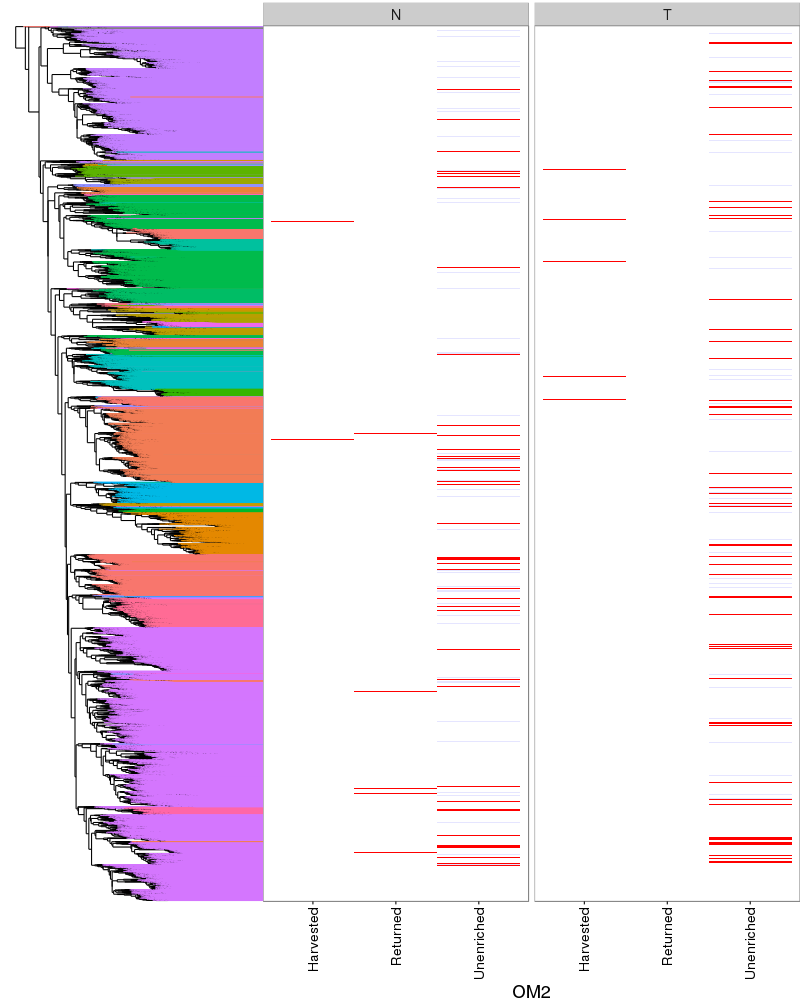

In [64]:
%%R -w 800 -h 1000
# tree plot
p.tree = plot_tree(physeq.Bulk, 
                   legend.title=' Phylum', 
                   y.expand=c(0.001,0.001),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Bulk, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_substrates_by_incorps(df.l2fc.ord, physeq.Bulk, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=2, 
 #                                             plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

 #plotting
gt = resize_ggplots(list(p.tree, p.incorp),#p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3))#,0.18,0.15))
do.call(grid.arrange, gt)

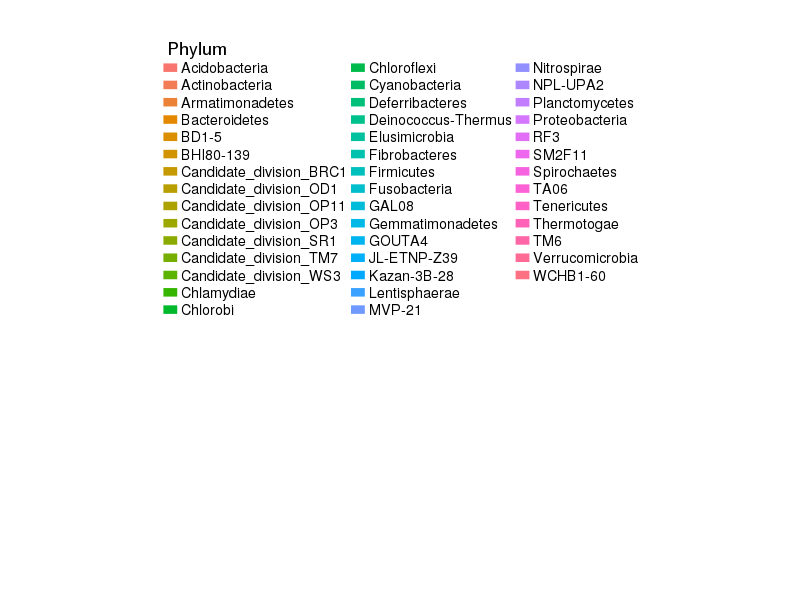

In [65]:
 %%R -w 800 -h 600
my.legend = g_legend(p.tree)
grid.draw(my.legend)

## full tree; just incorporators

In [66]:
%%R
# adding incorporator status to tax_table
padj.cutoff = 0.10

physeq.Bulk.inc = physeq.Bulk
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8) %>%
    group_by(OTU) %>%
    summarize(Incorporator = any(p_till <= padj.cutoff | p_OM <= padj.cutoff) %>% as.numeric) %>%
    ungroup() 

tax = physeq.Bulk.inc %>% tax_table %>% as.data.frame
tax$OTU = rownames(tax)
tax.j = left_join(df.l2fc.s, tax, c('OTU' = 'OTU')) %>% 
    mutate(Incorporator = ifelse(is.na(Incorporator), 0, Incorporator)) %>%
    as.data.frame() 
rownames(tax.j) = tax.j$OTU %>% as.character
tax.j$OTU = NULL

# making new phyloseq object with incorporator info
physeq.Bulk.inc = phyloseq(physeq.Bulk.inc %>% otu_table, 
                             tax.j %>% as.matrix %>% tax_table, 
                             physeq.Bulk.inc %>% sample_data,
                             physeq.Bulk.inc %>% phy_tree)
physeq.Bulk.inc = subset_taxa(physeq.Bulk.inc, Incorporator==1)
physeq.Bulk.inc

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2096 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 2096 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2096 tips and 2095 internal nodes ]


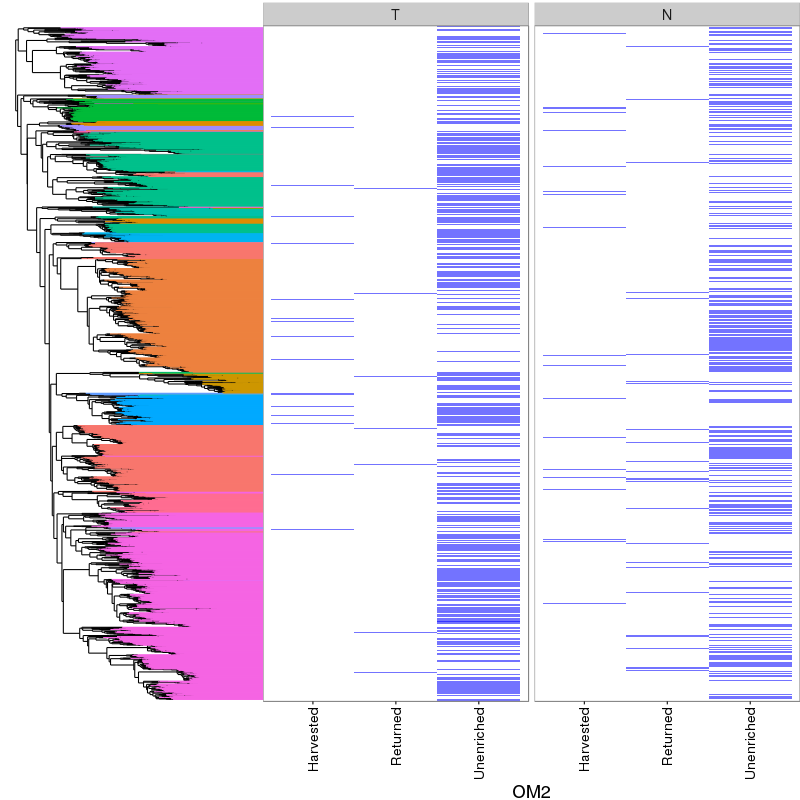

In [67]:
%%R -w 800 -h 800

p.tree = plot_tree(physeq.Bulk.inc, 
                   #legend.ftitle=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
#df.l2fc$Month = factor(df.l2fc$Month, levels = c("April", "June", "July", "August", "September", "October", "November"))
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)

## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Bulk.inc, df.l2fc.s) 
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
## substrates by similarity of incorporators
df.l2fc.ord = order_substrates_by_incorps(df.l2fc.ord, physeq.Bulk.inc, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1.25, 
 #                                             plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3))#,0.18,0.15))
do.call(grid.arrange, gt)

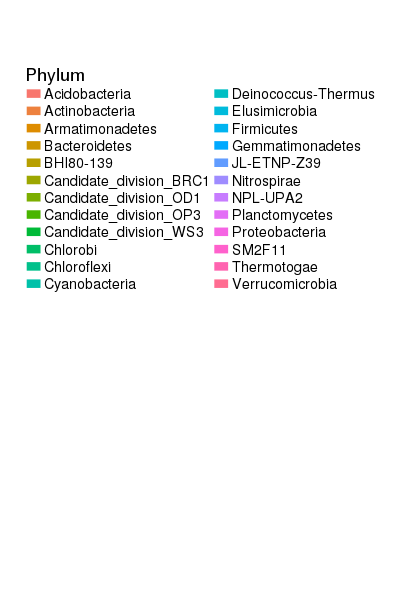

In [68]:
 %%R -w 400 -h 600
my.legend = g_legend(p.tree)
grid.draw(my.legend)

### Simple plot: not bulk abundance data

In [69]:
%%R
# saving figure
outFile = 'Bulk_NT_PT_September.3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=800 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [70]:
%%R 
# saving legend
outFile = 'allPhyla-inc_September_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


# Figures for each phylum

In [71]:
%%R
# ordering substrates by full tree order (all incorporators)
full.tree.ord = df.l2fc.ord$ls %>% levels
full.tree.ord

NULL


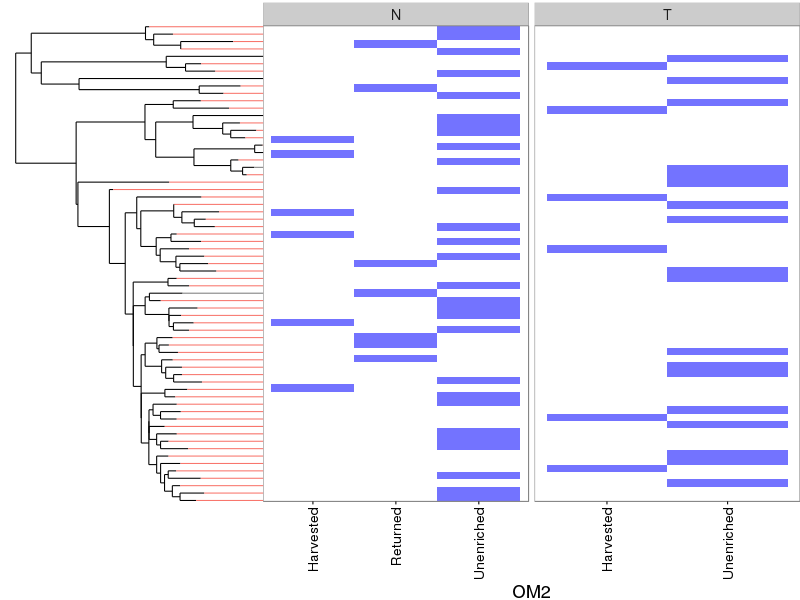

In [72]:
%%R -w 800 -h 600

# phylum selection
phylum = "__Candidate_division_WS3"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8) 
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3))#,0.18,0.15))
do.call(grid.arrange, gt)

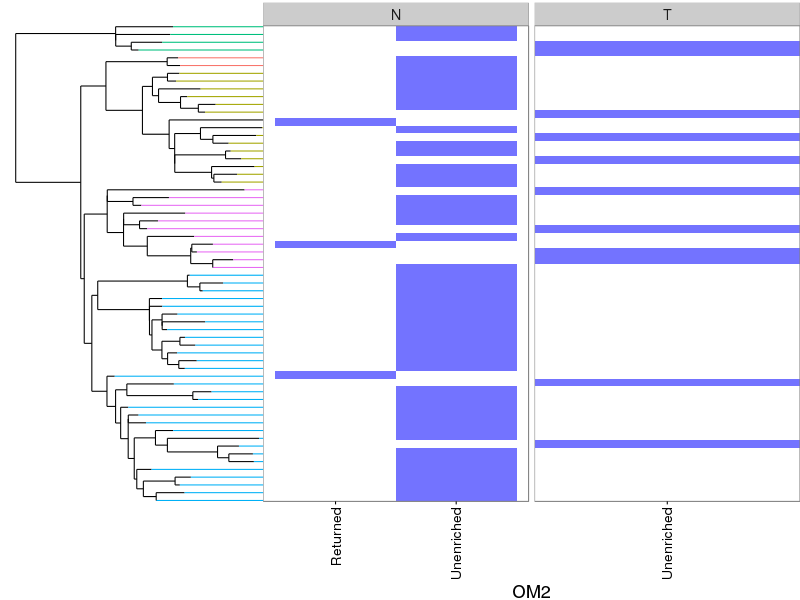

In [73]:
%%R -w 800 -h 600

# phylum selection
phylum = "__Verrucomicrobia"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8) 
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.7,1.3))#,0.18,0.15))
do.call(grid.arrange, gt)

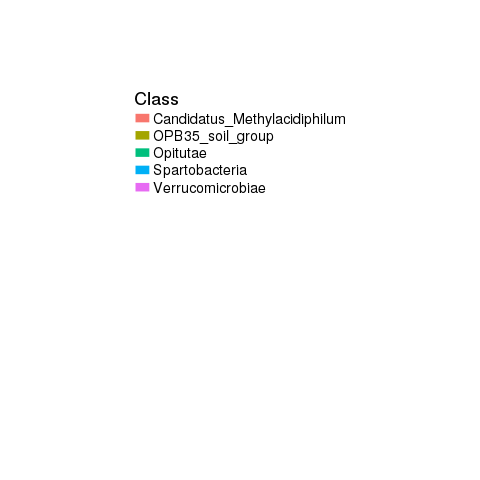

In [74]:
%%R
my.legend = g_legend(p.tree)
grid.draw(my.legend)

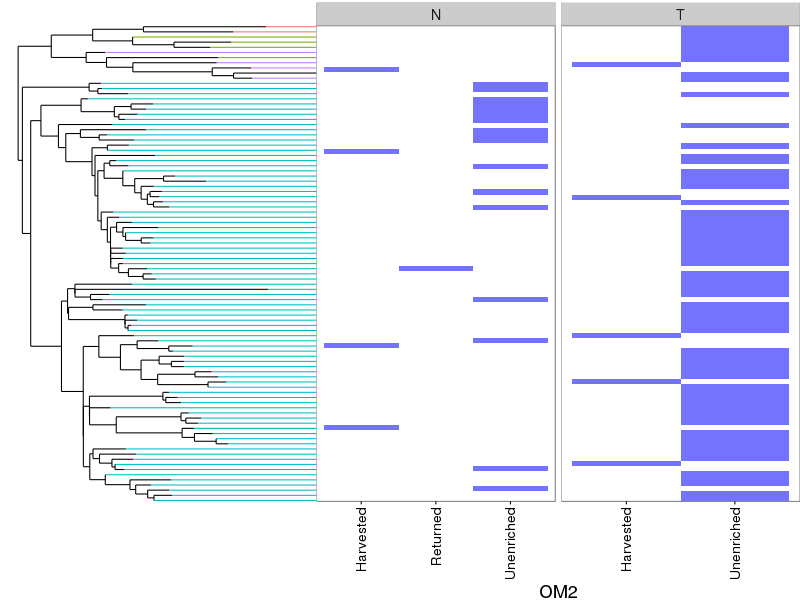

In [75]:
%%R -w 800 -h 600

# phylum selection
phylum = "__Gemmatimonadetes"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.5,.7))#,0.18,0.15))
do.call(grid.arrange, gt)

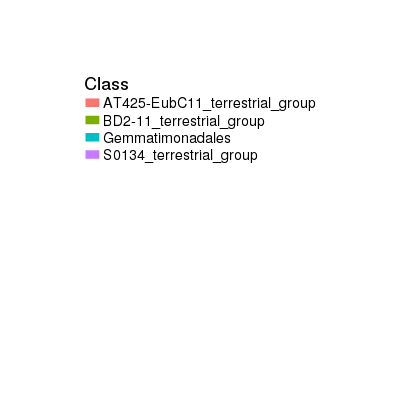

In [76]:
%%R -w 400 -h 400
my.legend = g_legend(p.tree)
grid.draw(my.legend)

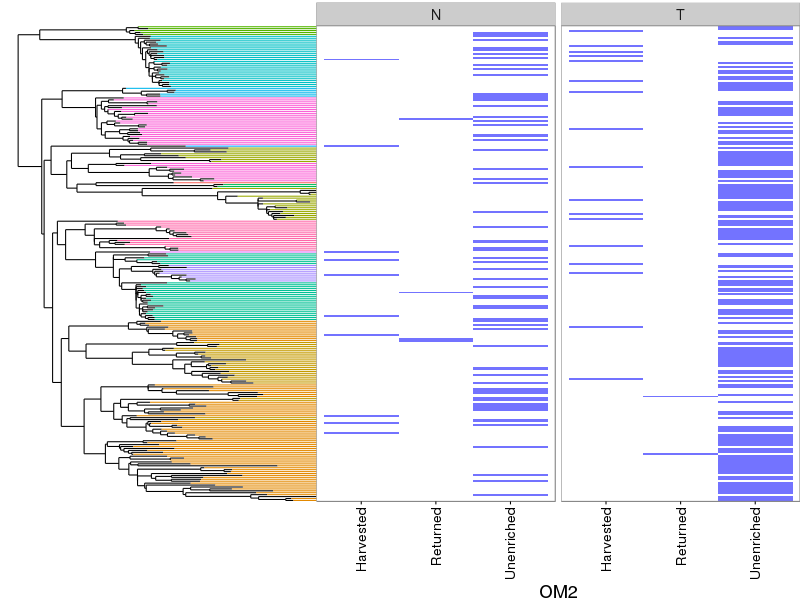

In [77]:
%%R -w 800 -h 600

# phylum selection
phylum = "__Chloroflexi"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.5,.7))#,0.18,0.15))
do.call(grid.arrange, gt)

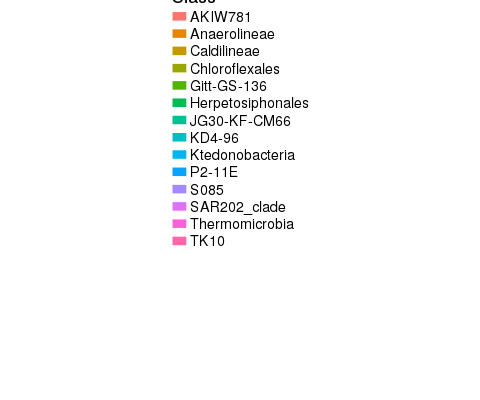

In [78]:
%%R -h 400
my.legend = g_legend(p.tree)
grid.draw(my.legend)

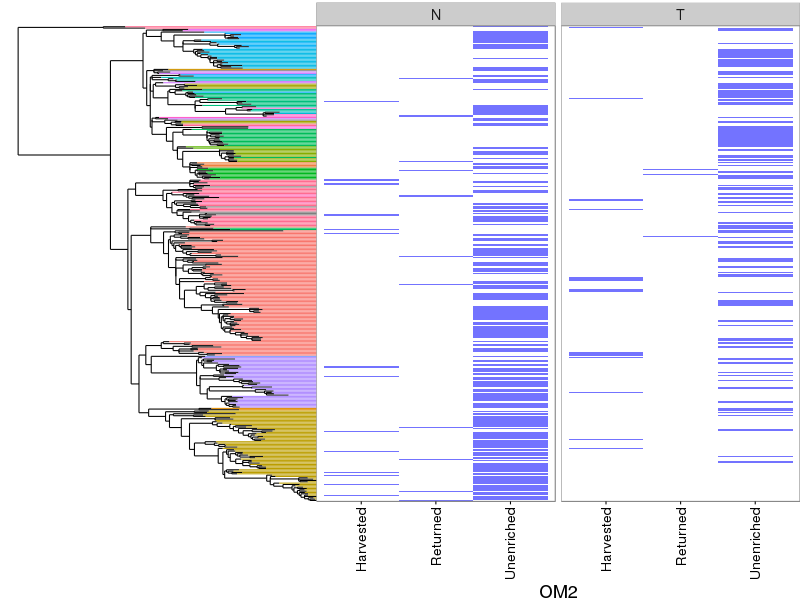

In [79]:
%%R -w 800 -h 600

# phylum selection
phylum = "__Actinobacteria"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4', 
                   legend.title='Order',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.5,.7))#,0.18,0.15))
do.call(grid.arrange, gt)

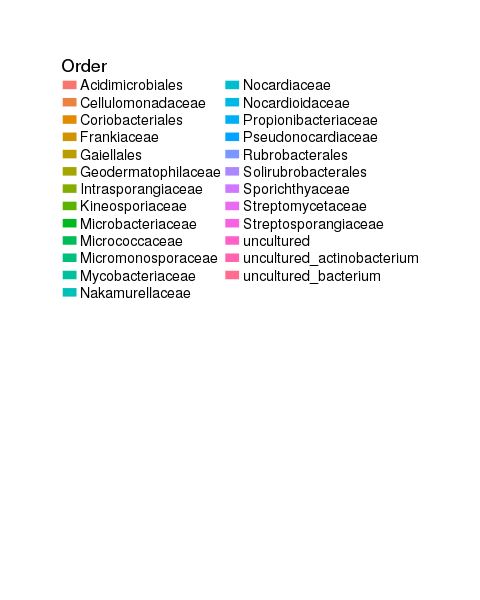

In [80]:
%%R -h 600
my.legend = g_legend(p.tree)
grid.draw(my.legend)

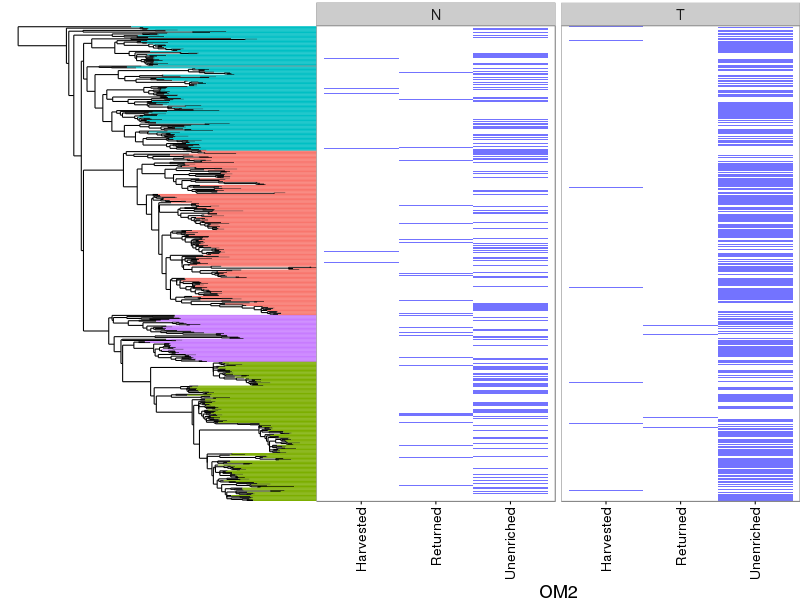

In [81]:
%%R -w 800 -h 600

# phylum selection
phylum = "__Proteobacteria"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.5,.7))#,0.18,0.15))
do.call(grid.arrange, gt)

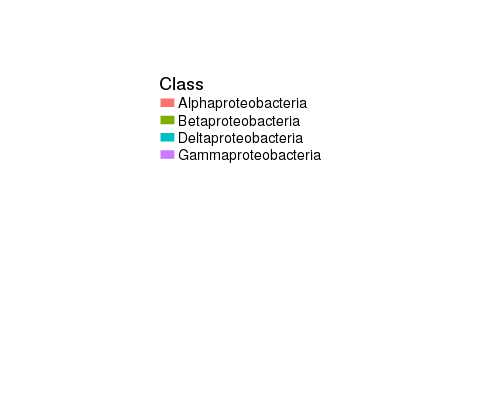

In [82]:
%%R -h 400
my.legend = g_legend(p.tree)
grid.draw(my.legend)

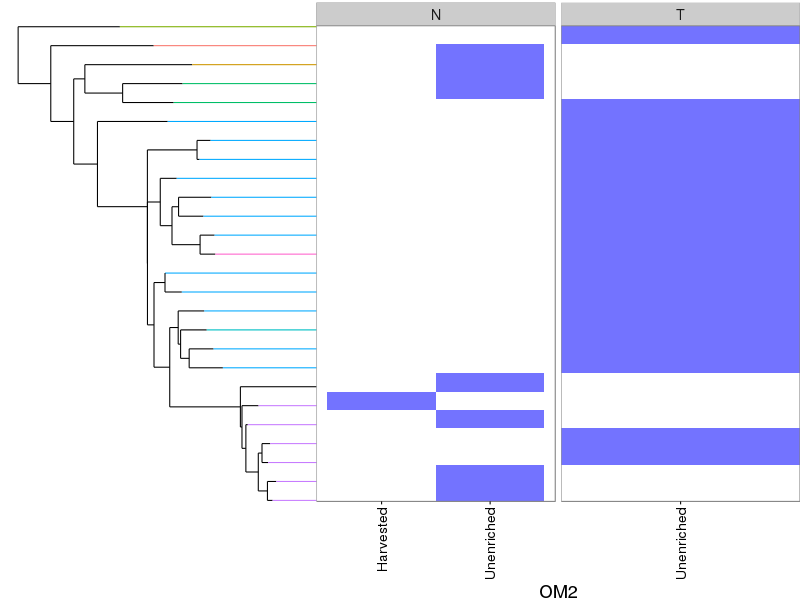

In [83]:
%%R -w 800 -h 600

# phylum selection
phylum = "__Cyanobacteria"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.5,.7))#,0.18,0.15))
do.call(grid.arrange, gt)

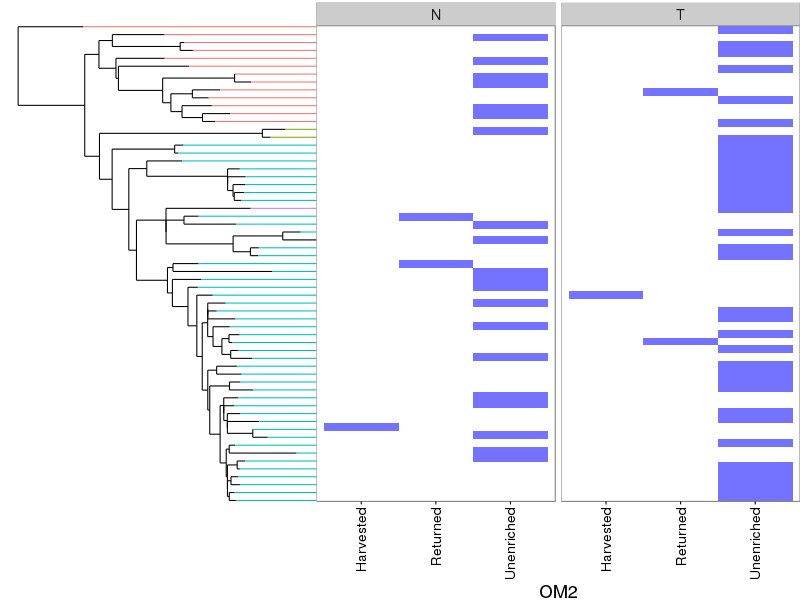

In [84]:
%%R -w 800 -h 600

# phylum selection
phylum = "__Bacteroidetes"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.5,.7))#,0.18,0.15))
do.call(grid.arrange, gt)

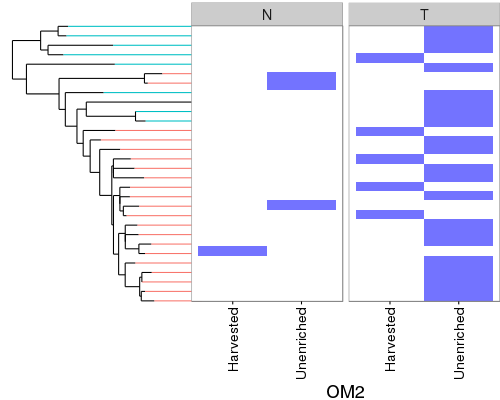

In [85]:
%%R -w 500 -h 400

# phylum selection
phylum = "__Firmicutes"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.5,.7))#,0.18,0.15))
do.call(grid.arrange, gt)

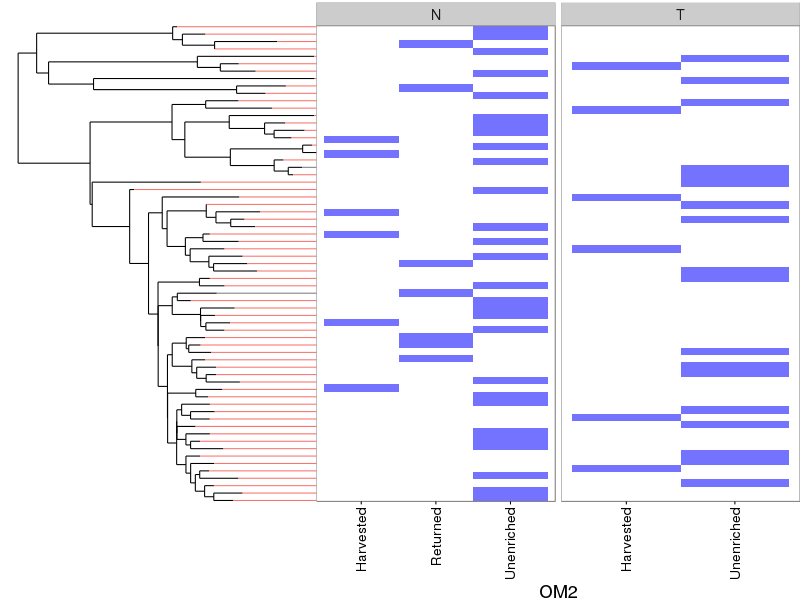

In [86]:
%%R -w 800 -h 600

# phylum selection
phylum = "__Candidate_division_WS3"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.5,.7))#,0.18,0.15))
do.call(grid.arrange, gt)

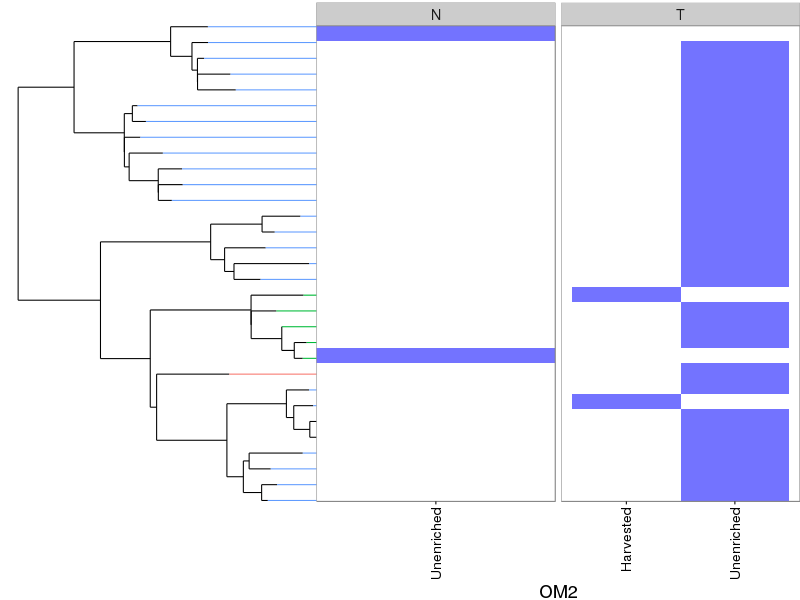

In [87]:
%%R -w 800 -h 600

# phylum selection
phylum = "__Armatimonadetes"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.5,.7))#,0.18,0.15))
do.call(grid.arrange, gt)

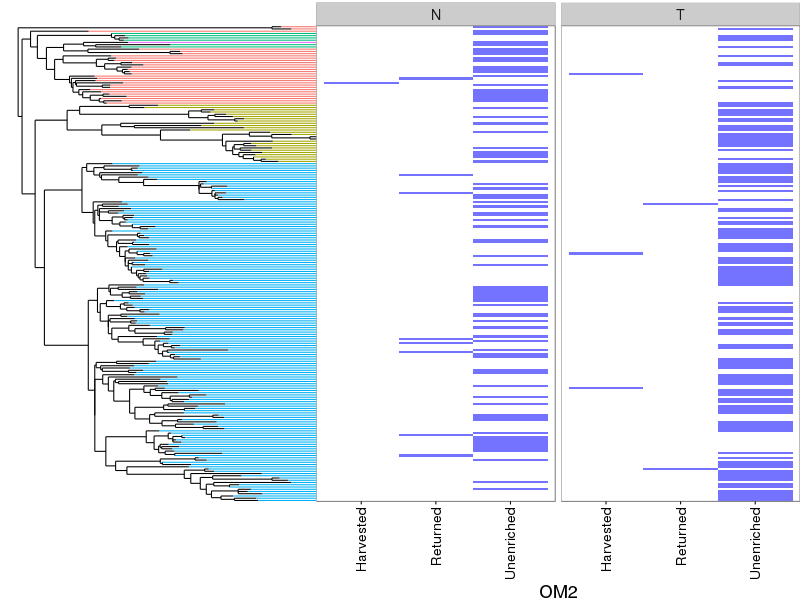

In [88]:
%%R -w 800 -h 600

# phylum selection
phylum = "__Planctomycetes"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.5,.7))#,0.18,0.15))
do.call(grid.arrange, gt)

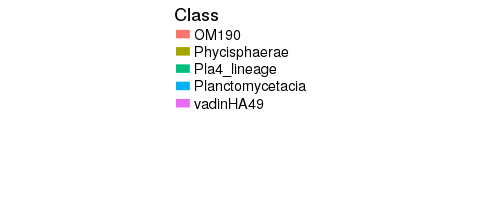

In [89]:
%%R -h 200
my.legend = g_legend(p.tree)
grid.draw(my.legend)

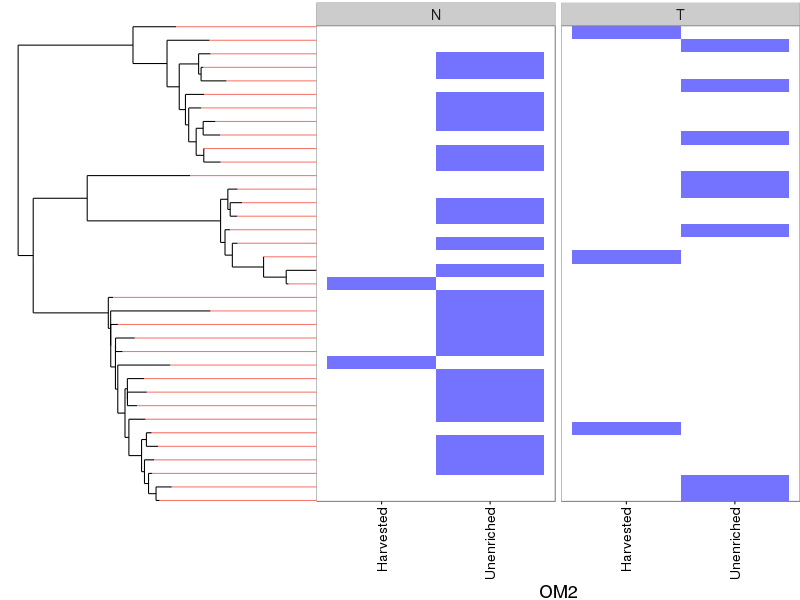

In [90]:
%%R -w 800 -h 600

# phylum selection
phylum = "__Nitrospirae"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.5,.7))#,0.18,0.15))
do.call(grid.arrange, gt)

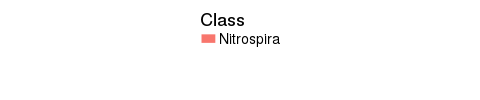

In [91]:
%%R -h 100
my.legend = g_legend(p.tree)
grid.draw(my.legend)

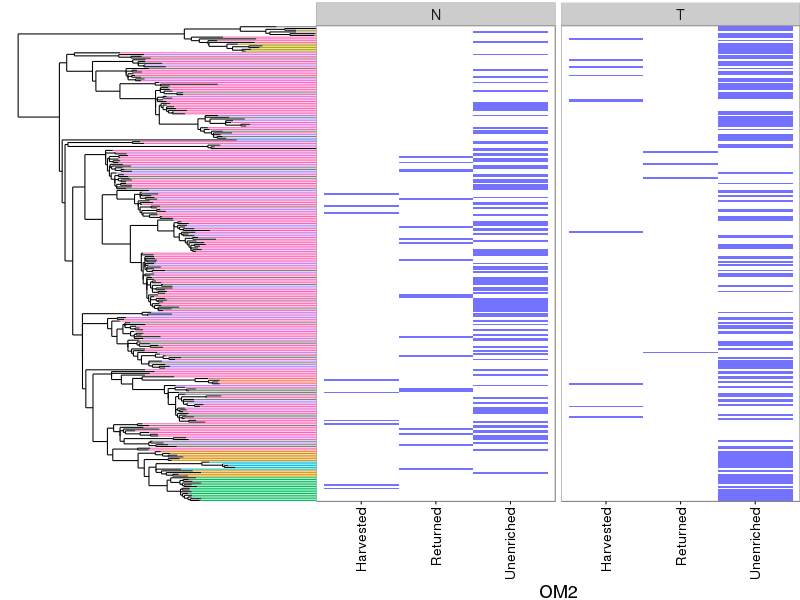

In [92]:
%%R -w 800 -h 600

# phylum selection
phylum = "__Acidobacteria"
physeq_1phy = subset_taxa(physeq.Bulk.inc, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4', 
                   legend.title='Order',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
#df.l2fc.ord$ls = paste(df.l2fc.ord$Treatment, df.l2fc.ord$Land_Management, sep = "-")
#df.l2fc.ord$ls = factor(df.l2fc.ord$ls, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord)

# bulk abundance plots
#df.bulk = bulk_abund_plot_df(physeq.bulk, df.l2fc.ord) 
#p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0,-0.4), 'cm'))
#p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                             # plot.margin=unit(c(2,0.2,2,-0.38), 'cm'))

# plotting
gt = resize_ggplots(list(p.tree, p.incorp),#, p.rel.abund, p.rel.total.abund),
                    widths=c(0.5,.7))#,0.18,0.15))
do.call(grid.arrange, gt)

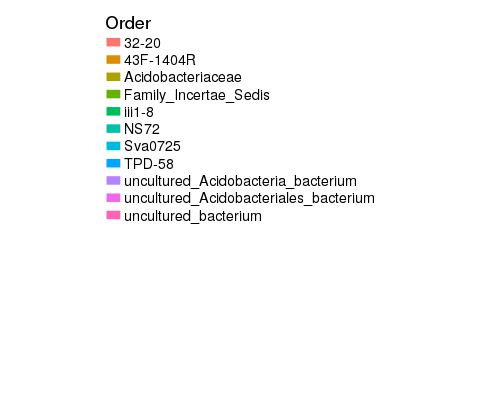

In [93]:
%%R -h 400
my.legend = g_legend(p.tree)
grid.draw(my.legend)

# ~ old ~

## Full tree

In [94]:
%%R -w 800 -h 1500
# tree plot
p.tree = plot_tree(physeq.thresh, legend.title=' Phylum', 
                   legend.position=c(0.01,0.15), 
                   plot.margin=unit(c(0,0,0,1.5), "cm"))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.thresh, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_substrates_by_incorps(df.l2fc.ord, physeq.thresh, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(1.81,0,1.62,-0.8), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(1.81,0,1.62,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=2, plot.margin=unit(c(1.81,0.1,1,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))


Error in phy_tree(physeq) : 
  error in evaluating the argument 'physeq' in selecting a method for function 'phy_tree': Error: object 'physeq.thresh' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 35 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [95]:
%%R -w 800 -h 2000
# larger size

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(2.63,0,2.45,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(2.63,0,2.45,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=2, plot.margin=unit(c(2.63,0.1,1.83,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))


Error in withVisible({ : could not find function "bulk_abund_plot_df"


In [96]:
%%R -i figDir

outFile = 'allPhyla_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=2000 / 65)


p.tree = plot_tree(physeq.thresh, legend.title=' Phylum', 
                   legend.position=c(0.01,0.15), 
                   plot.margin = unit(c(-0.75,-0.2,-0.7,1.5), "cm") )
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

NameError: name 'figDir' is not defined

### Just incorporators

In [ ]:
%%R
# adding incorporator status to tax_table
padj.cutoff = .10

physeq.thresh.inc = physeq.thresh
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8) %>%
    group_by(OTU) %>%
    summarize(Incorporator = any(padj < padj.cutoff) %>% as.numeric) %>%
    ungroup() 

tax = physeq.thresh.inc %>% tax_table %>% as.data.frame
tax$OTU = rownames(tax)
tax.j = left_join(tax, df.l2fc.s, c('OTU' = 'OTU')) %>% 
    mutate(Incorporator = ifelse(is.na(Incorporator), 0, Incorporator)) %>%
    as.data.frame() 
rownames(tax.j) = tax.j$OTU %>% as.character
tax.j$OTU = NULL

physeq.thresh.inc = phyloseq(physeq.thresh.inc %>% otu_table, 
                             tax.j %>% as.matrix %>% tax_table, 
                             physeq.thresh.inc %>% sample_data,
                             physeq.thresh.inc %>% phy_tree)
physeq.thresh.inc = subset_taxa(physeq.thresh.inc, Incorporator==1)
physeq.thresh.inc

In [ ]:
%%R -w 800 -h 800

# tree plot
p.tree = plot_tree(physeq.thresh.inc, legend.title=' Phylum', 
                   legend.position=c(0.01,0.15), 
                   plot.margin=unit(c(1.25,0,1.22,1.5), "cm"))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.thresh.inc, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_substrates_by_incorps(df.l2fc.ord, physeq.thresh, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(1.81,0,1.62,-0.8), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(1.81,0,1.62,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=2, plot.margin=unit(c(1.81,0.1,1,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [ ]:
%%R -i figDir

outFile = 'allPhyla-inc_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1000 / 65)


p.tree = plot_tree(physeq.thresh.inc, legend.title=' Phylum', 
                   legend.position=c(0.01,0.15), 
                   plot.margin=unit(c(0.71,0,0.74,1.5), "cm"))
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

# Figures for each phylum

In [ ]:
%%R
# ordering substrates by full tree order (all incorporators)
full.tree.ord = df.l2fc.ord$Substrate %>% levels
full.tree.ord

In [ ]:
%%R
# total OTU counts for each day (for normalizing)
# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.thresh, df.l2fc.s) 

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 

# total OTU counts for bulk soils
total.counts = df.bulk %>% 
    group_by(Day) %>%
    summarize(total_count = sum(count)) %>%
    as.data.frame 

total.counts

In [ ]:
%%R
physeq.thresh.tax = physeq.thresh %>% tax_table %>% as.matrix %>% as.data.frame
physeq.thresh.tax$Rank2 %>% table %>% sort(decreasing=T)

## Proteobacteria

In [ ]:
%%R -w 800 -h 1300

# phylum selection
phylum = "__Proteobacteria"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, color.rank='Rank3', legend.title='Class')

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(1.52,0,1.32,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              plot.margin=unit(c(1.52,0.1,0.7,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [ ]:
%%R -i figDir

outFile = 'Proteo_sparsityCut.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
p.tree = plot_tree(physeq_1phy, color.rank='Rank3', legend.title='Class', 
                   plot.margin = unit(c(-0.19,-0.2,-0.2,1.5), "cm") )
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

In [ ]:
%%R -w 800 -h 500

# Class selection
phylum = "__Gammaproteobacteria"
physeq_1phy = subset_taxa(physeq.thresh, Rank3==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4',
                   legend.title='Order',
                   legend.position=c(0,0.1),
                   plot.margin=unit(c(0,0,0.64,1.5), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0.2,0,0.69,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0.2,0,0.69,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0.2,0.1,0,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [ ]:
%%R -i figDir

outFile = 'Gamma_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=500 / 65)
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

In [ ]:
%%R -w 800 -h 500

# Class selection
phylum = "__Alphaproteobacteria"
physeq_1phy = subset_taxa(physeq.thresh, Rank3==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4',
                   legend.title='Order',
                   legend.position=c(0,0.1),
                   plot.margin=unit(c(0,0,0.64,1.5), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0.2,0,0.69,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0.2,0,0.69,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0.2,0.1,0,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [ ]:
%%R -i figDir

outFile = 'Alpha_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=500 / 65)

p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4',
                   legend.title='Order',
                   legend.position=c(0,0.1),
                   plot.margin=unit(c(-0.1,0,0.64,1.5), 'cm'))
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

## Actinobacteria

In [ ]:
%%R -w 800 -h 1000

# phylum selection
phylum = "__Actinobacteria"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, color.rank='Rank3', legend.title='Class')

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(1.02,0,0.86,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(1.02,0,0.88,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(1.02,0.1,0.18,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [ ]:
%%R -i figDir

outFile = 'Actino_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
p.tree = plot_tree(physeq_1phy, color.rank='Rank3', legend.title='Class', 
                   plot.margin = unit(c(-0.75,-0.2,-0.7,1.5), "cm") )
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

## Planctomycetes

In [ ]:
%%R -w 800 -h 1000

# phylum selection
phylum = "__Planctomycetes"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum, legend.title='Class')

# tree plot
p.tree = plot_tree(physeq_1phy, color.rank='Rank3')

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(1.02,0,0.86,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(1.02,0,0.88,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(1.02,0.1,0.20,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

## Acidobacteria

In [ ]:
%%R -w 800 -h 1000

# phylum selection
phylum = "__Acidobacteria"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, color.rank='Rank3', 
                   legend.position=c(0.1,0.2), legend.title='Class')

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord) 
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(1.02,0,0.86,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(1.02,0,0.88,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(1.02,0.1,0.20,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

## Chloroflexi

In [ ]:
%%R -w 800 -h 500

# phylum selection
phylum = "__Chloroflexi"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.05,0.25),
                   plot.margin=unit(c(0,0,0.64,1.5), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0.2,0,0.69,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0.2,0,0.69,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0.2,0.1,0,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

## Bacteroidetes

In [ ]:
%%R -w 800 -h 500

# phylum selection
phylum = "__Bacteroidetes"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.05,0.25),
                   plot.margin=unit(c(0,0,0.64,1.5), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0.2,0,0.69,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0.2,0,0.69,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0.2,0.1,0,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

## Verrucomicrobia

In [ ]:
%%R -w 800 -h 500

# phylum selection
phylum = "__Verrucomicrobia"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.05,0.25),
                   plot.margin=unit(c(0,0,0.73,1.5), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0.2,0,0.78,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0.2,0,0.78,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0.2,0.1,0.1,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [ ]:
%%R -i figDir

outFile = 'Verruco_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=500 / 65)
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

## Firmicutes 

In [ ]:
%%R -w 800 -h 500

# phylum selection
phylum = "__Firmicutes"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.05,0.25),
                   plot.margin=unit(c(0,0,0.67,1.5), 'cm'))


# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord) 
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)


# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0.15,0,0.69,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0.15,0,0.69,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0.15,0.1,0,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))

In [ ]:
%%R -i figDir

outFile = 'Firmicutes_sparCut0.35.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=500 / 65)
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))
dev.off()

## Gemmatimonadetes

In [ ]:
%%R -w 800 -h 300

# phylum selection
phylum = "__Gemmatimonadetes"
physeq_1phy = subset_taxa(physeq.thresh, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   legend.position=c(0.05,0.25),
                   plot.margin=unit(c(0.14,0,1,1.5), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord$Substrate = factor(df.l2fc.ord$Substrate, levels=full.tree.ord)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.incorp = incorp_plot(df.l2fc.ord, plot.margin=unit(c(0,0,0.69,-0.73), 'cm'))

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.thresh, df.l2fc.ord) 
p.rel.abund = bulk_rel_abund_plot(df.bulk, plot.margin=unit(c(0,0,0.69,-0.4), 'cm'))
p.rel.total.abund = bulk_rel_total_abund_plot(df.bulk, bar.width=1, 
                                              total.counts=total.counts,
                                              round.digits=1,
                                              plot.margin=unit(c(0,0.1,0,-0.38), 'cm'))

# plotting
grid.arrange(p.tree, p.incorp, p.rel.abund, p.rel.total.abund, ncol=4, widths=c(1,1.3,0.18,0.15))